## German-English Translation using Seq2Seq LSTM

In this notebook I will be demonstrating a basic seq2seq model for machine translation using LSTM. Seq2Seq models can be thought of as an extention to normal seqence models which can be used when the seqence lengths of inputs and targets differ. Examples for such problems include machine translation, caption generation etc. 

The basic architecture of such a model is as follows:

#### The encoder 

The encoder encodes the information from the input seqences into a single thought vector. This thought vector is nothing but the final hidden state of the encoder LSTM network. Here, we do not need the entire output from the LSTM but just the final hidden state. The encoder network, as the name implies is similar to the auto encoders that are used to learn representations of inputs without providing a target labels to train on. 

#### The decoder 

The decoder is the second LSTM network used in the seq2seq models. As the name suggests it decodes the information recieved from the encoder. The final hidden state from the encoder is used as the inintial hidden state of the decoder. The structure of a basic decoder LSTM is more or less similar to the LSTM used in the poetry generation example. The difference here is that, instead of using our own custom initial states, we will be using the finial states of the encoder as the initial states of the decoer. Again, we will be using teacher forcing to train the decoder network. 

#### Generative model 

Like in the poetry example, we will use a new generative model to generate some sample translations. 

#### Note

Unlike the poetry example, we will need to do every operaion such as tokenizing, word to idx mapping and padding twice. This must be done in this way since this a translation task and we are working with two different languages. 


Link to download the pre-trained word embeddings:  http://nlp.stanford.edu/data/glove.6B.zip

Link to download the translation training texts:  http://www.manythings.org/anki/

### Basic Imports


In [2]:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

C:\Users\ambar\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Constants

In [1]:
BATCH_SIZE = 64
EPOCHS = 10
HIDDEN_DIM = 256
NUM_SAMPLES = 10000  # Number of samples to train on, we will truncate the original file since it is too large. 
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

### Loading data

In [3]:
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [4]:
text = 0

for line in open('deu.txt',encoding='utf8'):
    
    text = text+1
    
    if text > NUM_SAMPLES:
        break
   
    if '\t' not in line:
        continue
        
    input_text, translation = line.split('\t')
    
    target_text = translation + ' <eos>'
    target_text_input = '<sos> ' + translation
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)
    
print('Number of Samples:', len(input_texts))

Number of Samples: 10000


In [5]:
print(len(target_texts))

10000


In [6]:
print(len(target_texts_inputs))

10000


We can see that our input texts has been truncated to the NUM_SAMPLES

### Tokenizing
We will need two different tokenizers for two languages.

This also means we will need two word to index mapping, bascially we will need to do all the operation we did in poetry generation twice. 

#### Tokenizer 1 (inputs)

In [7]:
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

#### Word to index mapping (inputs)

In [8]:
word2idx_inputs = tokenizer_inputs.word_index
print('Found {} unique tokens:'.format(len(word2idx_inputs)))

Found 2339 unique tokens:


In [9]:
max_len_input = max(len(s) for s in input_sequences)
print('Max input length',max_len_input)

Max input length 5


#### Tokenizer 2 (targets)

In [10]:
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) 
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

#### Word to index mapping (targets)

In [11]:
word2idx_outputs = tokenizer_outputs.word_index
print('Found {} unique tokens:'.format(len(word2idx_outputs)))

Found 5225 unique tokens:


In [12]:
num_words_output = len(word2idx_outputs) + 1

In [13]:
max_len_target = max(len(s) for s in target_sequences)
print('Max len targets:',max_len_target)

Max len targets: 11


### Padding 

Why pre padding for inputs and post padding for targets?

This is done so that the padded 0's are not getting multiplied with each other. 

In [14]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [  0   0   0   0 541]


In [15]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_inputs[0]: [   2 1103    0    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 11)


In [16]:
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print("decoder_targets[0]:", decoder_targets[0])
print("decoder_targets.shape:", decoder_targets.shape)

decoder_targets[0]: [1103    1    0    0    0    0    0    0    0    0    0]
decoder_targets.shape: (10000, 11)


### Loading Glove Vectors

In [17]:
word2vec = {}
with open(os.path.join('glove.6B/glove.6B.100d.txt'),encoding='utf8') as f:
  
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found {} word vectors'.format(len(word2vec)))

Found 400000 word vectors


### Creating Embedding matrix

In [18]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

In [19]:

for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        
        embedding_vector = word2vec.get(word)
    
        if embedding_vector is not None:
     
          embedding_matrix[i] = embedding_vector

In [20]:
embedding_matrix.shape

(2340, 100)

### Building Model

#### Embedding layer 

In [21]:
embedding_layer = Embedding(num_words,EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_len_input,
                           trainable = True)

#### One hot targets

In [22]:
decoder_targets_one_hot = np.zeros((len(input_texts),max_len_target,num_words_output),dtype=np.float32)

In [23]:
for i,d in enumerate(decoder_targets):
    
    for t,word in enumerate(d):
        
        decoder_targets_one_hot[i,t,word] = 1

In [24]:
decoder_targets_one_hot.shape

(10000, 11, 5226)

#### Encoder

In [25]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))

In [26]:
x = embedding_layer(encoder_inputs_placeholder)

In [28]:
encoder = LSTM(HIDDEN_DIM,return_state=True)

In [29]:
encoder_outputs,h,c = encoder(x)

In [30]:
# keep only the states to pass into decoder
encoder_states = [h,c]

#### Decoder

In [31]:
decoder_inputs_placeholder = Input(shape=(max_len_target,))

In [32]:
decoder_embedding = Embedding(num_words_output, HIDDEN_DIM)

In [33]:
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [34]:
decoder_lstm = LSTM(HIDDEN_DIM,return_sequences=True,return_state=True)

In [35]:
decoder_outputs,_,_ = decoder_lstm(decoder_inputs_x,initial_state=encoder_states)

In [36]:
decoder_dense = Dense(num_words_output, activation='softmax')

In [37]:
decoder_outputs = decoder_dense(decoder_outputs)

In [38]:
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [39]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

##### The model takes in two inputs - One each for the encoder and decoder and one output which is our target. We have two inputs because we are using teacher forcing, otherwise we would simply pass the previous state output as the input to the next state.


In [40]:
train = model.fit([encoder_inputs, decoder_inputs], decoder_targets_one_hot,batch_size=BATCH_SIZE,verbose=1,
               epochs=EPOCHS,validation_split=0.2,)


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 64s 8ms/step - loss: 2.3286 - acc: 0.6829 - val_loss: 2.2158 - val_acc: 0.6947
Epoch 2/10
8000/8000 [==============================] - 64s 8ms/step - loss: 1.6821 - acc: 0.7488 - val_loss: 2.0215 - val_acc: 0.7241
Epoch 3/10
8000/8000 [==============================] - 64s 8ms/step - loss: 1.4793 - acc: 0.7753 - val_loss: 1.9095 - val_acc: 0.7366
Epoch 4/10
8000/8000 [==============================] - 62s 8ms/step - loss: 1.3413 - acc: 0.7916 - val_loss: 1.8289 - val_acc: 0.7503
Epoch 5/10
8000/8000 [==============================] - 62s 8ms/step - loss: 1.2283 - acc: 0.8043 - val_loss: 1.7536 - val_acc: 0.7597
Epoch 6/10
8000/8000 [==============================] - 62s 8ms/step - loss: 1.1352 - acc: 0.8151 - val_loss: 1.7416 - val_acc: 0.7648
Epoch 7/10
8000/8000 [==============================] - 62s 8ms/step - loss: 1.0521 - acc: 0.8243 - val_loss: 1.6939 - val_acc: 0.7708
Epoch 8

### Plotting some results 

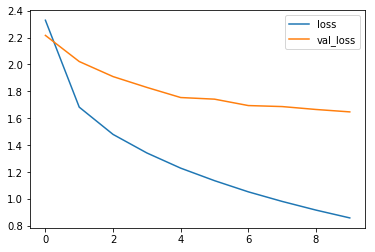

In [41]:
plt.plot(train.history['loss'], label='loss')
plt.plot(train.history['val_loss'], label='val_loss')
plt.legend()

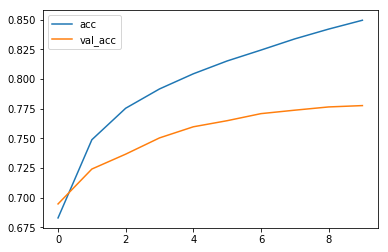

In [42]:
plt.plot(train.history['acc'], label='acc')
plt.plot(train.history['val_acc'], label='val_acc')
plt.legend()

### Generative Model 

Just line poetry example, we will create another model to generate translation. This model will take the previous LSTM state as input to the next state and generate translation one at a time, i.e the no:of time steps in the generative modle will be 1.

We will use the final state from the encoder as the initial state to the decoder just like in training. 



#### Setting up the model 

In [43]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [44]:
decoder_state_input_h = Input(shape=(HIDDEN_DIM,))
decoder_state_input_c = Input(shape=(HIDDEN_DIM,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]

In [45]:
# This is the input to the decoder LSTM that will generate translation one at a time 

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [48]:
decoder_outputs, h, c =  decoder_lstm(decoder_inputs_single_x,initial_state=decoder_states_inputs)

In [49]:
decoder_states = [h, c]

In [50]:
decoder_outputs = decoder_dense(decoder_outputs)

In [51]:
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)


#### Mapping indexes back to real words 

In [52]:
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

#### Sampling Function

In [53]:
def gen_model (input_seq):
    
    states_value = encoder_model.predict(input_seq)

  
    target_seq = np.zeros((1, 1))

  
    target_seq[0, 0] = word2idx_outputs['<sos>']

  
    eos = word2idx_outputs['<eos>']

 
    output_sentence = []
    
    for _ in range(max_len_target):
        
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        # Grab next word
        
        idx = np.argmax(output_tokens.flatten())

        # End sentence of EOS
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        
        target_seq[0, 0] = idx

        # Update states
        
        states_value = [h, c]
        
        

    return ' '.join(output_sentence)


### Generating Translation 

Like Poetry generation we will generate the translation as an infinite loop 

In [55]:
while True:
    
    i = np.random.choice(len(input_texts))
    
    english_input = encoder_inputs[i:i+1]
    
    german_translation = gen_model(english_input)
    
    print('-------------')
    
    print('English Input:',input_texts[i])
    print('\n')
    print('Predicted translation:',translation)
    print('\n')
    print('Actual translation:',target_texts[i])
    
    ans = input('Continue? Y or N')
    
    if ans and ans.lower().startswith('n'):
        break 

-------------
English Input: Are you up?


Predicted translation: Tom hat mehrere Möglichkeiten.



Actual translation: Bist du auf?
 <eos>
Continue? Y or Ny
-------------
English Input: I saw a dog.


Predicted translation: Tom hat mehrere Möglichkeiten.



Actual translation: Ich habe einen Hund gesehen.
 <eos>
Continue? Y or Ny
-------------
English Input: That one's OK.


Predicted translation: Tom hat mehrere Möglichkeiten.



Actual translation: Das da ist OK.
 <eos>
Continue? Y or Nn


We can see that this is not a good translation at all since the model is just returning the same translated senetence over and over. This is one of the major chanllenges involved when training such models. Since the objective of the model is always to minimize the training loss, it will find a pattern from the entire input seqence that will help the model to achieve this objective. In other words, this can also be considered as overfitting. 

I have demonstrated how Attention mechanism solves this problem in another notebook.